Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv n'existe pas.
Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed_summary.csv n'existe pas.
Fréquences de coupure estimées pour XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.csv: [1.0]


/var/folders/05/yrqprpyx0pq3802sw_y8kcj00000gn/T/ipykernel_9066/3171659089.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return snr.fillna(method='bfill').fillna(method='ffill')


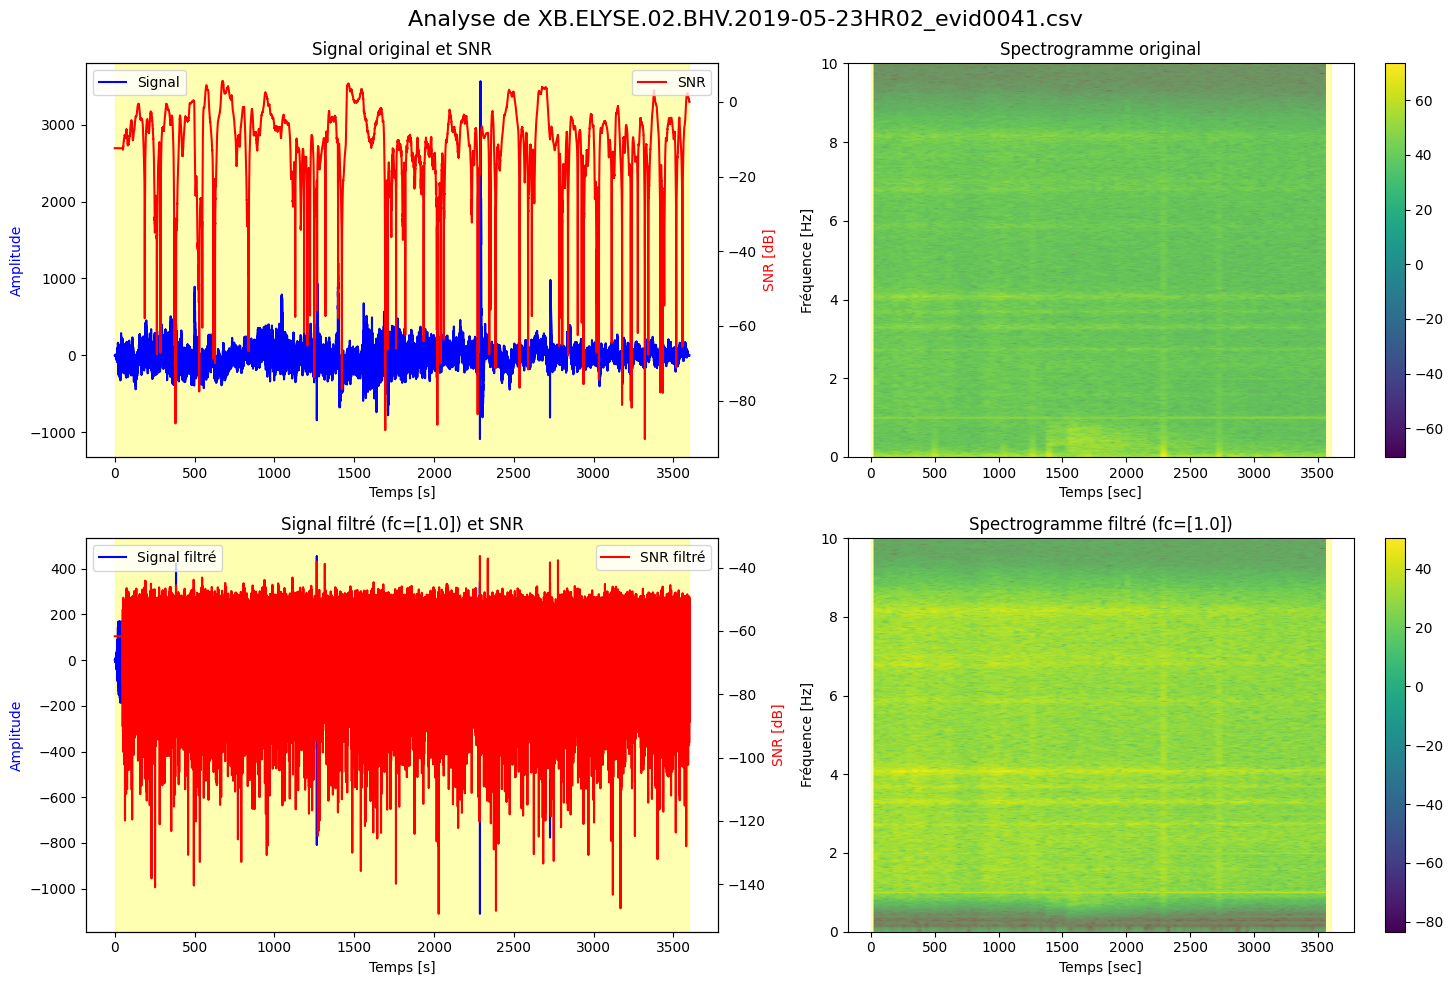

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed_summary.csv
Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed_summary.csv n'existe pas.
Fréquences de coupure estimées pour XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.csv: [1.0]


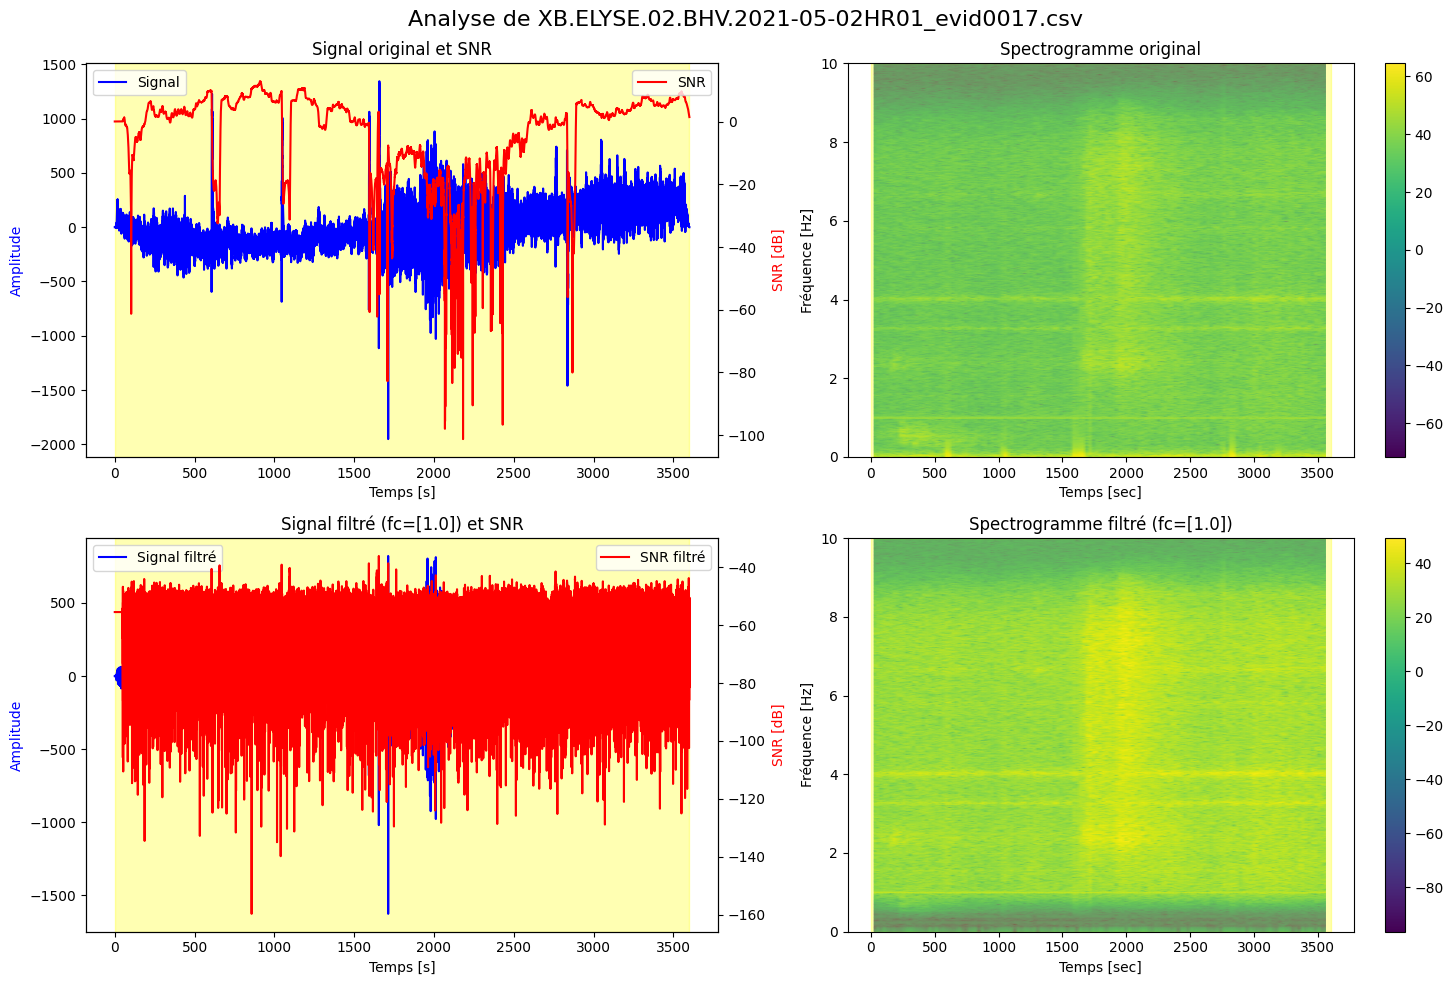

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed_summary.csv
Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed_summary.csv n'existe pas.
Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed_summary.csv n'existe pas.
Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed_summary.csv n'existe pas.
Fréquences de coupure estimées pour XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.csv: [1.0]


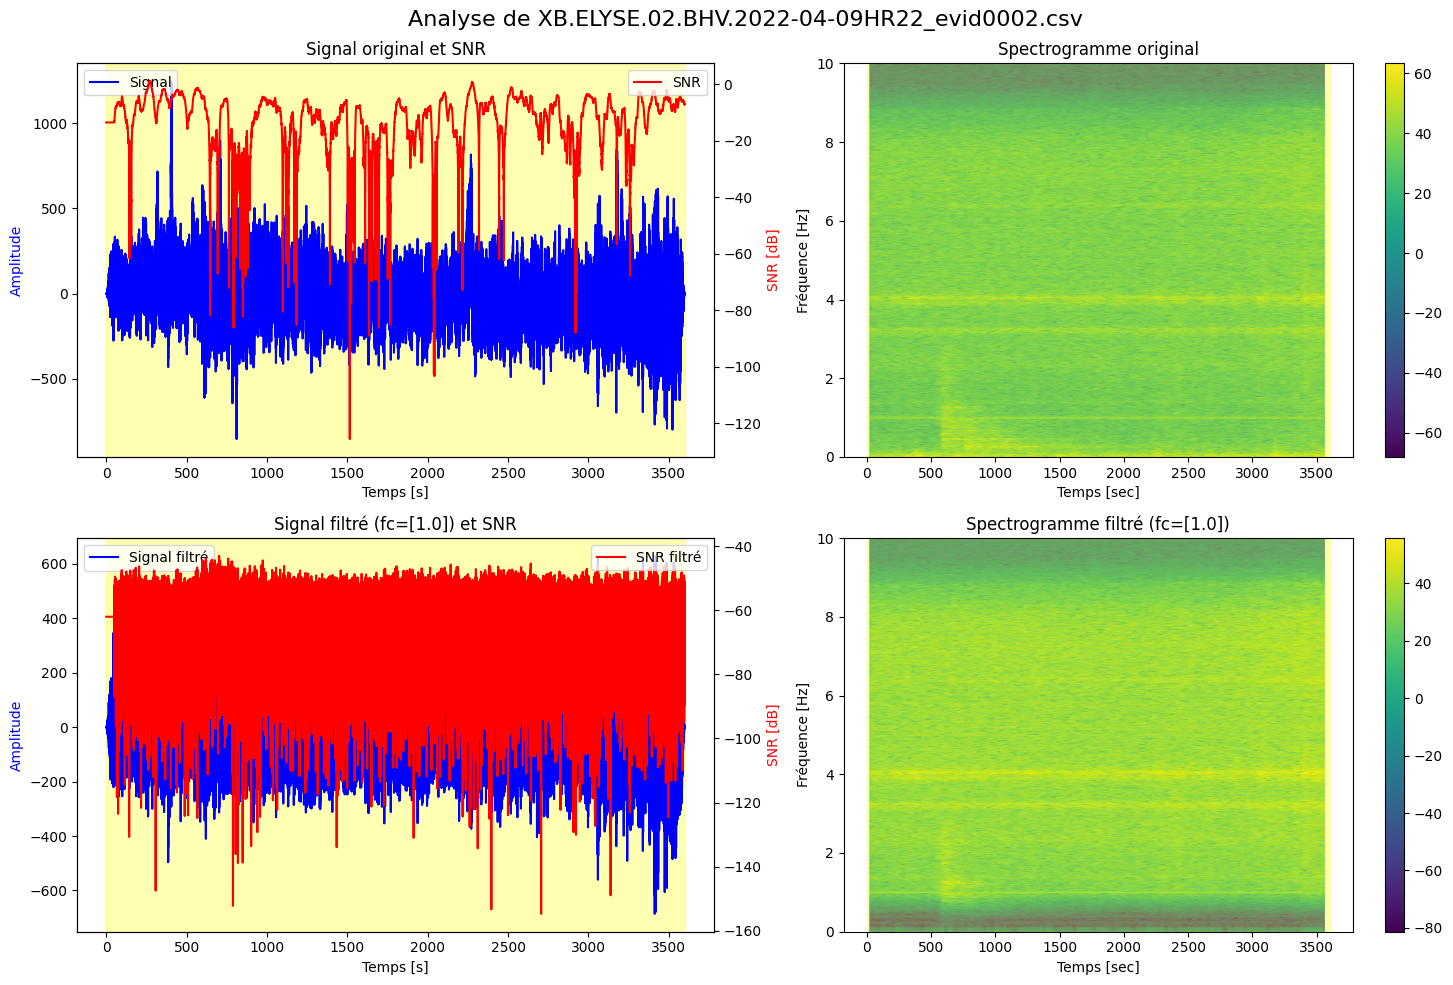

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed_summary.csv
Fréquences de coupure estimées pour XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.csv: [1.0]


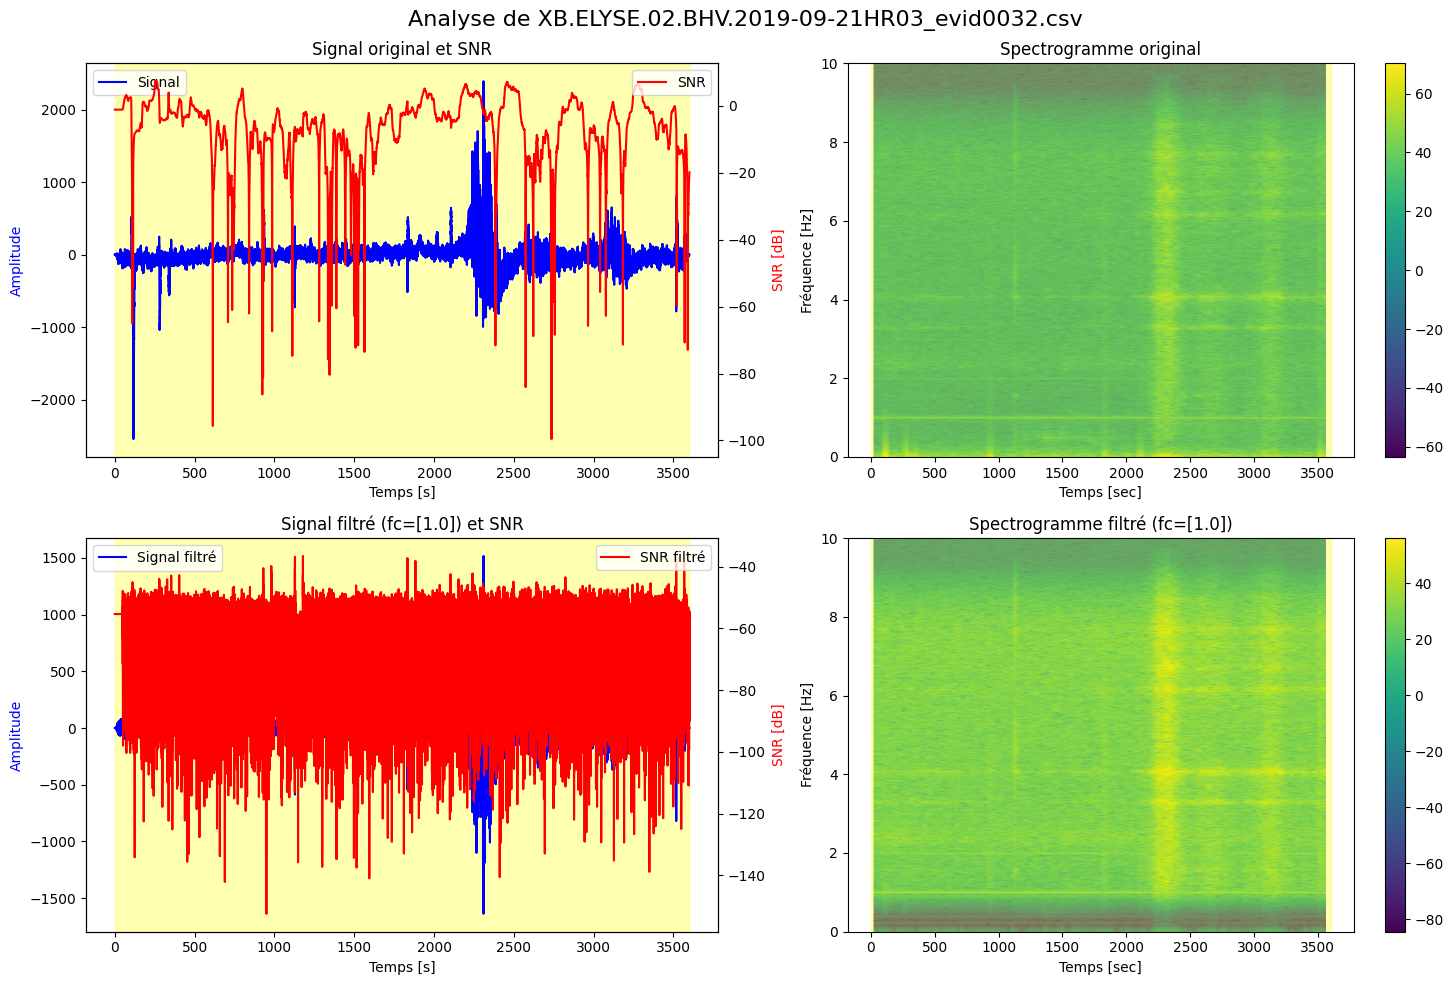

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed_summary.csv
Fréquences de coupure estimées pour XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.csv: [1.0]


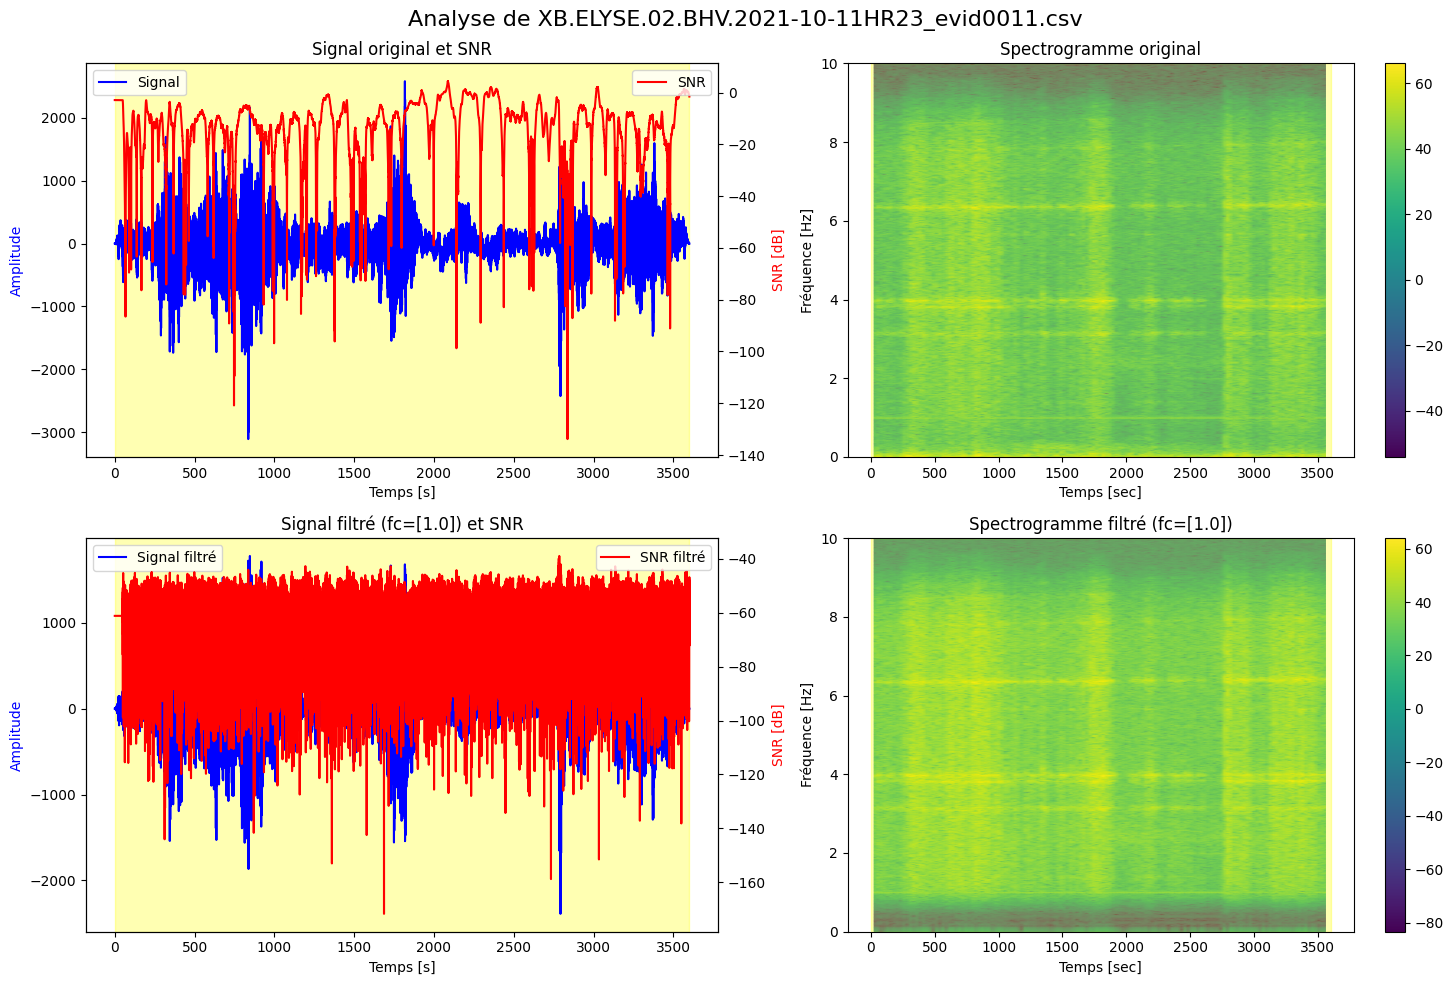

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed_summary.csv
Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed_summary.csv n'existe pas.
Le fichier MSEED correspondant à XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed_summary.csv n'existe pas.
Fréquences de coupure estimées pour XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.csv: [1.0]


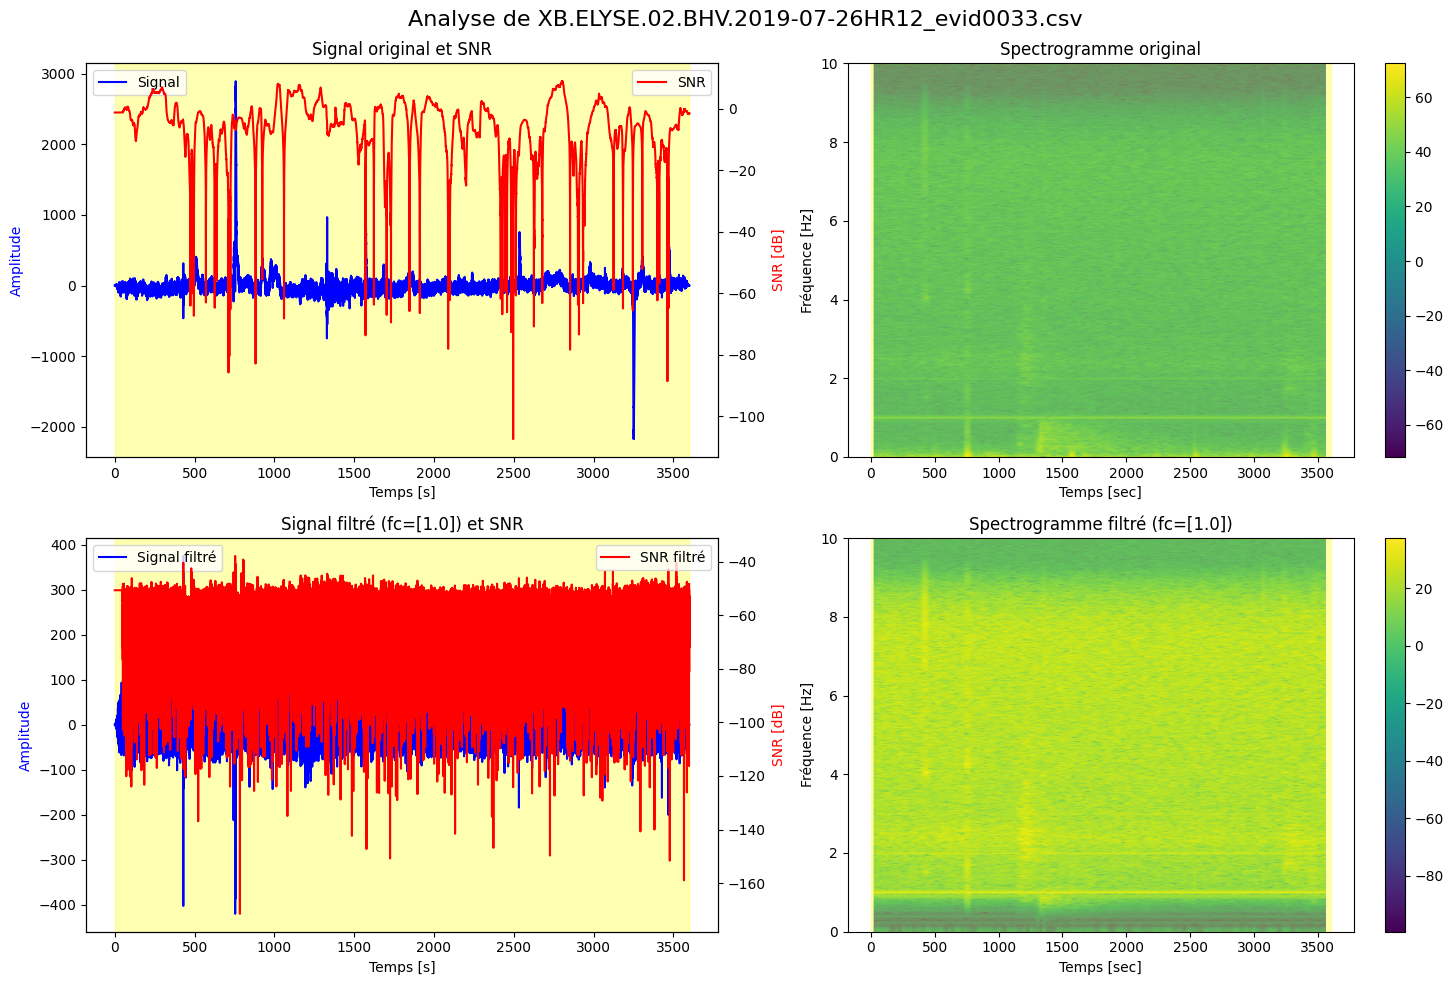

Résumé sauvegardé dans : ./data/mars/test/data/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed_summary.csv
Fréquences de coupure estimées pour XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.csv: [2.143529771246823, 2.200530562924485, 2.2007805663967552]


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from scipy.signal import butter, filtfilt, spectrogram
from scipy.fft import fft, fftfreq
import os

def butter_highpass(cutoff, fs, order=5):
    """Crée un filtre passe-haut Butterworth."""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoffs, fs):
    """Applique plusieurs filtres passe-haut Butterworth au signal en cascade."""
    y = data.copy()
    for cutoff in cutoffs:
        b, a = butter_highpass(cutoff, fs)
        y = filtfilt(b, a, y)
    return y

def calculate_snr(data, window_size=1000):
    """Calcule le rapport signal/bruit (SNR) du signal."""
    rolling_mean = pd.Series(data).rolling(window=window_size).mean()
    rolling_std = pd.Series(data).rolling(window=window_size).std()
    snr = 20 * np.log10(np.abs(rolling_mean / rolling_std))
    return snr.fillna(method='bfill').fillna(method='ffill')

def plot_spectrogram(data, fs, ax, title):
    """Génère et affiche un spectrogramme du signal."""
    f, t, Sxx = spectrogram(data, fs, nperseg=1024, noverlap=512)
    im = ax.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
    ax.set_title(title)
    ax.set_ylabel('Fréquence [Hz]')
    ax.set_xlabel('Temps [sec]')
    return im

def estimate_cutoff_frequencies(data, fs):
    """Estime plusieurs fréquences de coupure adaptées basées sur le spectre de fréquence du signal."""
    n = len(data)
    yf = fft(data)
    xf = fftfreq(n, 1/fs)[:n//2]
    yf = np.abs(yf[:n//2])
    
    # Trouver les pics dans le spectre de fréquence
    peaks = np.argsort(yf)[-3:]  # Prendre les 3 plus grands pics
    peak_freqs = xf[peaks]
    
    # Définir les fréquences de coupure comme 90% des fréquences des pics
    cutoffs = np.sort(peak_freqs * 0.9)
    
    # S'assurer que les fréquences de coupure sont au moins de 1 Hz et différentes
    cutoffs = np.unique(np.maximum(cutoffs, 1.0))
    
    return cutoffs.tolist()

def adaptive_sta_lta_thresholds(snr):
    """Calcule des seuils adaptatifs pour l'algorithme STA/LTA."""
    thr_on = np.percentile(snr, 95)  # 95ème percentile pour le seuil d'activation
    thr_off = np.percentile(snr, 50)  # 50ème percentile (médiane) pour le seuil de désactivation
    return thr_on, thr_off

def process_file(csv_file, cat_directory):
    """Traite un fichier sismique individuel."""
    cat_file = os.path.join(cat_directory, csv_file)
    mseed_file = cat_file.replace('.csv', '.mseed')
    
    if not os.path.exists(mseed_file):
        print(f"Le fichier MSEED correspondant à {csv_file} n'existe pas.")
        return None
    
    st = read(mseed_file)
    tr = st[0]
    tr_times = tr.times()
    tr_data = tr.data
    fs = tr.stats.sampling_rate
    
    snr = calculate_snr(tr_data)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Analyse de {csv_file}', fontsize=16)
    
    # Signal original et SNR
    axs[0, 0].plot(tr_times, tr_data, 'b', label='Signal')
    axs[0, 0].set_title('Signal original et SNR')
    axs[0, 0].set_xlabel('Temps [s]')
    axs[0, 0].set_ylabel('Amplitude', color='b')
    ax2 = axs[0, 0].twinx()
    ax2.plot(tr_times, snr, 'r', label='SNR')
    ax2.set_ylabel('SNR [dB]', color='r')
    axs[0, 0].legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Spectrogramme original
    im_orig = plot_spectrogram(tr_data, fs, axs[0, 1], 'Spectrogramme original')
    fig.colorbar(im_orig, ax=axs[0, 1])
    
    # Estimation des fréquences de coupure
    cutoff_freqs = estimate_cutoff_frequencies(tr_data, fs)
    print(f"Fréquences de coupure estimées pour {csv_file}: {cutoff_freqs}")
    
    # Filtrer le signal avec les filtres passe-haut en cascade
    tr_filtered = tr.copy()
    tr_filtered.data = highpass_filter(tr.data, cutoff_freqs, fs)
    filtered_snr = calculate_snr(tr_filtered.data)
    
    # Signal filtré et SNR filtré
    axs[1, 0].plot(tr_times, tr_filtered.data, 'b', label='Signal filtré')
    axs[1, 0].set_title(f'Signal filtré (fc={cutoff_freqs}) et SNR')
    axs[1, 0].set_xlabel('Temps [s]')
    axs[1, 0].set_ylabel('Amplitude', color='b')
    ax3 = axs[1, 0].twinx()
    ax3.plot(tr_times, filtered_snr, 'r', label='SNR filtré')
    ax3.set_ylabel('SNR [dB]', color='r')
    axs[1, 0].legend(loc='upper left')
    ax3.legend(loc='upper right')
    
    # Spectrogramme filtré
    im_filt = plot_spectrogram(tr_filtered.data, fs, axs[1, 1], f'Spectrogramme filtré (fc={cutoff_freqs})')
    fig.colorbar(im_filt, ax=axs[1, 1])
    
    # STA/LTA avec des fenêtres ajustées
    sta_len = 60  # 60 secondes pour STA
    lta_len = 300  # 300 secondes pour LTA
    cft = classic_sta_lta(tr_filtered.data, int(sta_len * fs), int(lta_len * fs))
    thr_on, thr_off = adaptive_sta_lta_thresholds(filtered_snr)
    on_off = trigger_onset(cft, thr_on, thr_off)
    
    for ax in axs.flatten():
        for on, off in on_off:
            ax.axvspan(tr_times[on], tr_times[off], alpha=0.3, color='yellow')
    
    plt.tight_layout()
    plt.show()
    
    event_times = [(tr_times[on], tr_times[off]) for on, off in on_off]
    amplitudes = [np.max(np.abs(tr_filtered.data[on:off])) for on, off in on_off]
    event_snrs = [np.mean(filtered_snr[on:off]) for on, off in on_off]
    
    summary_df = pd.DataFrame({
        'Event Start (s)': [event[0] for event in event_times],
        'Event End (s)': [event[1] for event in event_times],
        'Amplitude': amplitudes,
        'SNR': event_snrs
    })
    
    summary_file = f'{mseed_file}_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f"Résumé sauvegardé dans : {summary_file}")
    
    return summary_df

def main():
    cat_directory = './data/mars/test/data'
    csv_files = [f for f in os.listdir(cat_directory) if f.endswith('.csv')]

    all_summaries = []

    for csv_file in csv_files:
        summary = process_file(csv_file, cat_directory)
        if summary is not None:
            all_summaries.append(summary)

    if all_summaries:
        combined_summary = pd.concat(all_summaries, ignore_index=True)
        
        # Graphique Amplitude vs SNR
        plt.figure(figsize=(10, 6))
        plt.scatter(combined_summary['SNR'], combined_summary['Amplitude'], alpha=0.5)
        plt.xlabel('SNR [dB]')
        plt.ylabel('Amplitude')
        plt.title('Amplitude vs SNR pour tous les événements détectés')
        plt.colorbar(label='Densité')
        plt.show()
        
        # Graphique Amplitude vs Durée de l'événement
        plt.figure(figsize=(10, 6))
        combined_summary['Duration'] = combined_summary['Event End (s)'] - combined_summary['Event Start (s)']
        scatter = plt.scatter(combined_summary['Duration'], combined_summary['Amplitude'], 
                              c=combined_summary['SNR'], cmap='viridis', alpha=0.5)
        plt.xlabel('Durée de l\'événement [s]')
        plt.ylabel('Amplitude')
        plt.title('Amplitude vs Durée de l\'événement')
        plt.colorbar(scatter, label='SNR [dB]')
        plt.show()

if __name__ == "__main__":
    main()